# Multi-Modal Gaussian Process Variational Autoencoder (MM-GPVAE)

This is adopted to work on synthetic data of multi-area neural LFP data

------------------------------------------------------

## Imports and hyperparameters

In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import scipy as sp
import pylab as pl
import numpy as np
from sklearn.model_selection import train_test_split
import GP_fourier as gpf
from train import *
from misc import *
from neural_nets import *
from sklearn.cross_decomposition import CCA
import matplotlib as mpl

import os

torch.manual_seed(my_seed)
np.random.seed(my_seed)

## Load synthetic data

In [2]:
data_save_dir = r"F:\comp_project\synthecticData\data"

DATA_PRESETS_STAGE1_all = {
    # 1) Linear-ish baseline (DLAG-friendly; sanity check)
    "S0_linear_easy": dict(
        n_trials=100, T=250, fs=500, shared_dim=3, private_dim=3,
        bipolarize=True,
        spatial_mixing="none",
        nonlin_mode="static",
        shared_variant="identity",
        add_one_over_f=False, ar_stage="none",
        sensor_noise=0.01,
        add_row_common=False, add_common_mode=False,
        seed=701,
    ),

    # 2) Nonlinear mapping (region-mismatched warp + gain+bilinear), no hetero noise
    #    DLAG starts to degrade; SPIRE should hold
    "S1_warp_gainbilin": dict(
        n_trials=100, T=250, fs=500, shared_dim=3, private_dim=3,
        bipolarize=True,
        spatial_mixing="random",              # or "gaussian" if you want harsher bipolar effects
        nonlin_mode="gain+bilinear", gain_g=0.8, bilinear_beta=0.8,
        interaction_strength=0.2,
        shared_variant="identity",
        shared_warp="region_mismatch",
        add_one_over_f=True, one_over_f_strength=0.2,
        ar_stage="latents", ar1_rho=0.3,
        sensor_noise=0.02,
        add_row_common=False, add_common_mode=False,
        seed=702,
    ),

    "D3_timevary_delay": dict(
        n_trials=100, T=250, fs=500, shared_dim=3, private_dim=3,
        bipolarize=True,
        spatial_mixing="random",              # or "gaussian" if you want harsher bipolar effects
        nonlin_mode="gain+bilinear", gain_g=0.8, bilinear_beta=0.8,
        interaction_strength=0.2,
        shared_variant="identity",
        shared_warp="region_mismatch",
        timevary_delay=True, tvd_amplitude=3, tvd_cycles=1.0,   # <-- NEW
        add_one_over_f=True, one_over_f_strength=0.2,
        ar_stage="latents", ar1_rho=0.3,
        sensor_noise=0.02,
        add_row_common=False, add_common_mode=False,
        seed=702,
    ),
    
}

# reload from npz (preferred) or .mat
def load_saved_dataset(regime_name, config, data_dir):
    npz_path = os.path.join(data_dir, f"{regime_name}.npz")

    if os.path.exists(npz_path):
        data = dict(np.load(npz_path, allow_pickle=True))
    else:
        raise FileNotFoundError(f"No saved file found for {regime_name}")

    return {"regime": regime_name, "config": config, "data": data}

# rebuild ALL_DATASETS
ALL_DATASETS=[]
for regime_name, config in DATA_PRESETS_STAGE1_all.items():
    ALL_DATASETS.append(load_saved_dataset(regime_name, config, data_save_dir))

    
# sanity check
print(len(ALL_DATASETS), [d["regime"] for d in ALL_DATASETS])

3 ['S0_linear_easy', 'S1_warp_gainbilin', 'D3_timevary_delay']


In [3]:
OneData = ALL_DATASETS[1]

In [4]:
from torch.utils.data import Dataset, DataLoader

class TwoRegionLFPDataset(Dataset):
    def __init__(self, reg1, reg2):
        """
        reg1, reg2: tensors of shape (N, C, T) or (N, T, C) – just be consistent.
        """
        assert reg1.shape == reg2.shape
        self.reg1 = reg1
        self.reg2 = reg2

    def __len__(self):
        return self.reg1.shape[0]

    def __getitem__(self, idx):
        # returns one paired sample (region1, region2)
        return self.reg1[idx], self.reg2[idx]


In [5]:
# torch.manual_seed(my_seed)

# full_dataset = TimePointCustomDataset(DATA_PATH)
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size],
# generator=torch.Generator().manual_seed(DATA_SPLIT_SEED))
# loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
# loader_test= torch.utils.data.DataLoader(test_dataset, batch_size=BATCH)

In [6]:
# ## Unbatched data
# torch.manual_seed(my_seed)
# full_data = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH)
# train_data_unbatched = torch.utils.data.DataLoader(train_dataset, 
# batch_size=train_dataset.__len__())
# test_data_unbatched = torch.utils.data.DataLoader(test_dataset, 
# batch_size=test_dataset.__len__())

In [7]:
# ## Printing shapes & getting the meanrates to initialize our neural decoder
# for data, labels, spikes, neural_rates, gp1, gp2, zoom in train_data_unbatched:
#     print(f'Shape of images {data.shape}')
#     print(f'Shape of angles {labels.shape}')
#     print(f'Shape of spikes {spikes.shape}')
#     print(f'Shape of rates {neural_rates.shape}')
#     meanrates = np.mean(neural_rates.detach().numpy(), axis = (0,1))
#     break
    

## Build model

In [8]:
# region 1 (replaces "image"/behavior)
enc_region1 = LFP_Encode(zDim=N_lats_img,  # shared or private, depending on their naming
                         n_channels=8,
                         time_points=250)

dec_region1 = LFP_Decode(zDim=N_lats_img,
                         n_channels=8,
                         time_points=250)

# region 2 (replaces spikes)
enc_region2 = LFP_Encode(zDim=N_lats_spikes,
                         n_channels=8,
                         time_points=250)

dec_region2 = LFP_Decode(zDim=N_lats_spikes,
                         n_channels=8,
                         time_points=250)



## Training 

In [9]:

regime = OneData["regime"]
data = OneData["data"]

# unpack data
region1_data, region2_data = data["region1"], data["region2"] #N,T,C
print(np.shape(region1_data))
print(np.shape(region2_data))

# # Your helper builds lag-augmented features and returns (N, C*lags+1, T-lags)
# reg1_R, reg2_R = build_dataset_with_lag_lagged_stn_wo_vo(region1_data, region2_data, lags=LAGS)
# # print(np.shape(reg1_R))

# --- Convert to tensors and permute to (N, T, C) ---
reg1_tensor = torch.tensor(region1_data, dtype=torch.float32).permute(0, 2, 1)
reg2_tensor = torch.tensor(region2_data, dtype=torch.float32).permute(0, 2, 1)

# use all as train (adjust if you want a split)
reg1_train, reg2_train = reg1_tensor, reg2_tensor
reg1_test, reg2_test = reg1_tensor, reg2_tensor

(100, 250, 8)
(100, 250, 8)


In [10]:
BATCH = 32  # or whatever you like

train_dataset = TwoRegionLFPDataset(reg1_train, reg2_train)
loader_train = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

test_dataset = TwoRegionLFPDataset(reg1_test, reg2_test)
loader_test = DataLoader(test_dataset, batch_size=BATCH, shuffle=True)

N_lats_img = 6
N_lats_spikes = 6
N_shared = 3
Epoch 0 | Loss: -126416.45
Epoch 50 | Loss: -354110.75
Epoch 100 | Loss: -406334.64
Epoch 150 | Loss: -440182.86
Epoch 200 | Loss: -469831.04
Epoch 250 | Loss: -497038.73
Epoch 300 | Loss: -524298.08
Epoch 350 | Loss: -552658.44
Epoch 400 | Loss: -581419.78
Epoch 450 | Loss: -608938.63
Epoch 500 | Loss: -634698.02
Epoch 550 | Loss: -659311.64
Epoch 600 | Loss: -678419.71
Epoch 650 | Loss: -696656.77
Epoch 700 | Loss: -705144.15


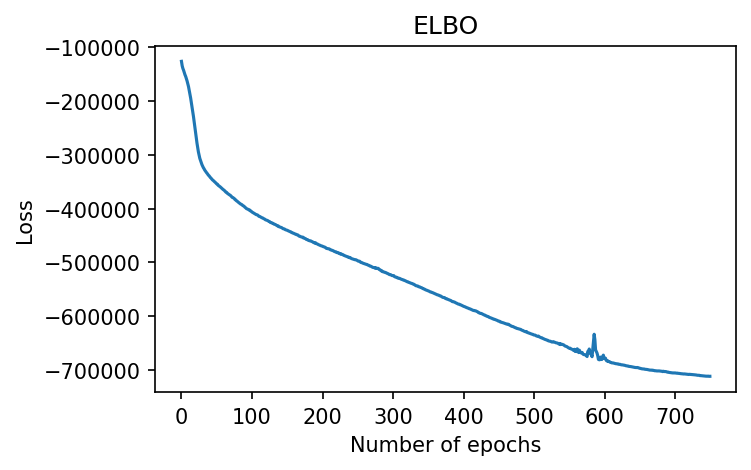

In [11]:

trained = train_mmgpvae_two_region(
    enc_region1, dec_region1,    # modality 1 = region 1
    enc_region2, dec_region2,    # modality 2 = region 2
    loader_train,
    EPOCH=750,
    lr1=0.00016, lr2=0.000124, lr3=0.000772, lr4=0.0088,
    Fourier=False,
    visualize_ELBO=True
)




In [12]:
# for dataset in ALL_DATASETS:
#     regime = dataset["regime"]
#     data = dataset["data"]

#     # unpack data
#     region1_data, region2_data = data["region1"], data["region2"] #N,T,C
#     print(np.shape(region1_data))
#     print(np.shape(region2_data))

#     # # Your helper builds lag-augmented features and returns (N, C*lags+1, T-lags)
#     # reg1_R, reg2_R = build_dataset_with_lag_lagged_stn_wo_vo(region1_data, region2_data, lags=LAGS)
#     # # print(np.shape(reg1_R))

#     # --- Convert to tensors and permute to (N, T, C) ---
#     reg1_tensor = torch.tensor(region1_data, dtype=torch.float32).permute(0, 2, 1)
#     reg2_tensor = torch.tensor(region2_data, dtype=torch.float32).permute(0, 2, 1)

#     # use all as train (adjust if you want a split)
#     reg1_train, reg2_train = reg1_tensor, reg2_tensor
#     reg1_test, reg2_test = reg1_tensor, reg2_tensor

## Visualizing the latent traces

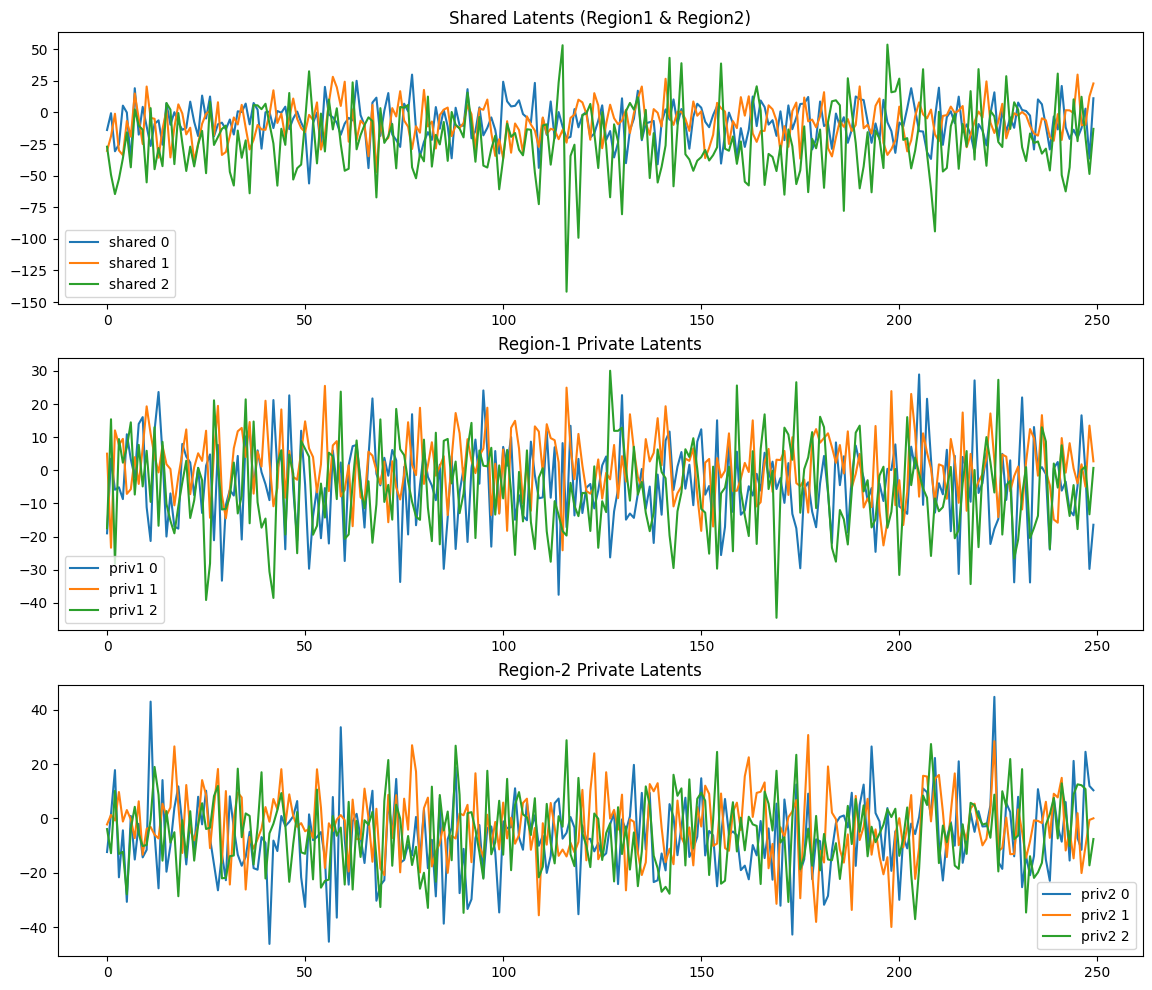

In [15]:
latents = visualize_latents_two_region(
    enc_region1, dec_region1,
    enc_region2, dec_region2,
    loader_train,
    num_trials=3,
    Fourier=False
)


### save the latents

In [13]:
import numpy as np
import torch

def extract_latents_two_region_all(
        net_encode, n_encode, data_loader,
        sample=False,          # False = use means, True = sample
        Fourier=False,
        save_path=None         # e.g. "mmgpvae_lfp_latents_test.npz"
    ):
    """
    Extracts latents for ALL trials from the two-region LFP MM-GPVAE.

    Returns a dict with Numpy arrays:
        'shared'  : (N, T, N_shared)          # common shared block
        'priv1'   : (N, T, N_lats_img - N_shared)    # region1-private
        'priv2'   : (N, T, N_lats_spikes - N_shared) # region2-private

    If save_path is given, saves them as a .npz file.
    """

    device = next(net_encode.parameters()).device

    all_shared = []
    all_priv1  = []
    all_priv2  = []

    net_encode.eval()
    n_encode.eval()

    with torch.no_grad():
        for reg1, reg2 in data_loader:
            reg1 = reg1.float().to(device)
            reg2 = reg2.float().to(device)

            # encode both regions → means & logvars in time domain
            embs_m_n,   embs_s_n   = n_encode(reg2, Fourier=Fourier)
            embs_m_img, embs_s_img = net_encode(reg1, Fourier=Fourier)

            # fuse into single latent with shared+private structure
            z_m_tot, z_logvar_tot = return_partitioned_latents(
                neural_embeds_m = embs_m_n,
                image_embeds_m  = embs_m_img,
                neural_embeds_s = embs_s_n,
                image_embeds_s  = embs_s_img,
                N_lats_spikes   = N_lats_spikes,
                N_lats_img      = N_lats_img,
                N_shared        = N_shared
            )

            # choose representation
            if sample:
                z = sample_latents(z_m_tot, z_logvar_tot)  # (B, T, N_tot)
            else:
                z = z_m_tot                               # (B, T, N_tot)

            # ---- split dimensions according to MM-GPVAE layout ----
            priv2_dim = N_lats_spikes - N_shared
            priv1_dim = N_lats_img    - N_shared
            N_tot     = N_lats_spikes + N_lats_img - N_shared

            # indices:
            # [0 : priv2_dim)                   → region2 private
            # [priv2_dim : priv2_dim+N_shared)  → shared
            # [N_lats_spikes : N_lats_spikes+priv1_dim) → region1 private

            shared_start = priv2_dim
            shared_end   = shared_start + N_shared

            z_shared = z[:, :, shared_start:shared_end]     # (B, T, N_shared)
            z_priv2  = z[:, :, :priv2_dim]                  # (B, T, priv2_dim)
            z_priv1  = z[:, :, N_lats_spikes:N_lats_spikes+priv1_dim]  # (B, T, priv1_dim)

            all_shared.append(z_shared.detach().cpu())
            all_priv1.append(z_priv1.detach().cpu())
            all_priv2.append(z_priv2.detach().cpu())

    # concat over batches ➜ (N, T, dim)
    all_shared = torch.cat(all_shared, dim=0).numpy()
    all_priv1  = torch.cat(all_priv1,  dim=0).numpy()
    all_priv2  = torch.cat(all_priv2,  dim=0).numpy()

    latents_dict = {
        "shared": all_shared,   # common shared block
        "priv1":  all_priv1,    # region 1 private
        "priv2":  all_priv2     # region 2 private
    }

    if save_path is not None:
        np.savez(
            save_path,
            shared=all_shared,
            priv1=all_priv1,
            priv2=all_priv2
        )
        print(f"Latents saved to {save_path}")

    return latents_dict


In [14]:
latents_save_dir = r"F:\comp_project\synthecticData\MMGPVAE"

latents_test = extract_latents_two_region_all(
    enc_region1, enc_region2,
    loader_test,
    sample=False,          # means are usually better for CCA
    Fourier=False,
    save_path= os.path.join(latents_save_dir, "mmgpvae_lfp_D1_latents_test_seed77_rep2.npz")
)

Latents saved to F:\comp_project\synthecticData\MMGPVAE\mmgpvae_lfp_D1_latents_test_seed77_rep2.npz


## CCA projection of latents to GT

In [19]:
# ---------- helpers ----------
def _to_numpy(arr):
    if hasattr(arr, "detach"):
        arr = arr.detach().cpu().numpy()
    return np.asarray(arr)

def _match_T_and_flatten(model_latents, gt_latents):
    """
    model_latents: (N, Tm, D)
    gt_latents   : (N, D, Tg)
    Returns:
      model_flat, gt_flat, Tm, D
    """
    model_latents = _to_numpy(model_latents)
    gt_latents    = _to_numpy(gt_latents)

    N, Tm, D = model_latents.shape
    # GT (N,D,Tg) -> (N,Tg,D) -> trim to last Tm
    gt_latents = np.transpose(gt_latents, (0, 2, 1))
    if gt_latents.shape[1] < Tm:
        raise ValueError(f"GT has shorter T ({gt_latents.shape[1]}) than model T ({Tm}).")
    gt_trim = gt_latents[:, -Tm:, :]   # (N, Tm, D)

    # Flatten across trials & time -> (N*Tm, D)
    model_flat = model_latents.reshape(-1, D)
    gt_flat    = gt_trim.reshape(-1, D)
    return model_flat, gt_flat, Tm, D, gt_trim

def _cca_align(model_latents, gt_latents):
    """
    Fit CCA on flattened (N*Tm,D), return aligned sequences back in (N,Tm,D) form.
    """
    model_flat, gt_flat, Tm, D, gt_trim_3d = _match_T_and_flatten(model_latents, gt_latents)

    # Zero-mean each set (helps numerical stability)
    model_flat_c = model_flat - model_flat.mean(axis=0, keepdims=True)
    gt_flat_c    = gt_flat    - gt_flat.mean(axis=0, keepdims=True)

    cca = CCA(n_components=D, scale=False, max_iter=5000, tol=1e-6)
    m_cca, g_cca = cca.fit_transform(model_flat_c, gt_flat_c)

    # Per-component Pearson r in CCA space
    cca_corrs = [np.corrcoef(m_cca[:, i], g_cca[:, i])[0, 1] for i in range(m_cca.shape[1])]

    # Reshape back to (N, Tm, D)
    N = model_latents.shape[0]
    m_cca_3d = m_cca.reshape(N, Tm, -1)
    g_cca_3d = g_cca.reshape(N, Tm, -1)

    return m_cca_3d, g_cca_3d, np.array(cca_corrs, dtype=float)

def plot_shared1_mean_sem2(
    spire_shared1, gt_shared1,
    dims=(0, 1, 2),
    T_clip=None,
    width_in=6.9,            # total figure width (two-column default)
    row_height_in=1.0,       # height per row (inches)
    base_fontsize=8,
    line_width=1.1,
    savepath=None,
    dpi=300,
    panel_labels=True,
    legend_headroom=0.12,
):
    """Mean±SEM of shared-1 latents; layout = 1 rows x len(dims) cols.
       Row 0: SPIRE [Comp d1..]; Row 1: DLAG [Comp d1..].
    """
    # Colors / styles
    model_color = "crimson"
    gt_color    = "teal"
    model_style = "-"
    gt_style    = "--"
    band_alpha  = 0.20

    # --- Per-model CCA alignment to GT (independent) ---
    spire_m, spire_g, spire_ccas = _cca_align(spire_shared1, gt_shared1)
    T_common = spire_m.shape[1]
    # --- Common time window ---
    if T_clip is not None:
        T_common = min(T_common, int(T_clip))
    spire_m, spire_g = spire_m[:, :T_common, :], spire_g[:, :T_common, :]
    x = np.arange(T_common)

    # --- Valid dims across models ---
    D_min = spire_m.shape[2]
    dims = tuple(d for d in dims if d < D_min)
    if not dims:
        raise ValueError(f"No valid dims to plot; min D across models is {D_min}.")

    # --- Mean ± SEM ---
    def mean_sem(a):
        N = a.shape[0]
        m = a.mean(axis=0)
        s = a.std(axis=0, ddof=1)/np.sqrt(N) if N > 1 else np.zeros_like(m)
        return m, s

    spire_m_mean, spire_m_sem = mean_sem(spire_m)
    spire_g_mean, spire_g_sem = mean_sem(spire_g)

    # --- Figure at final size: 2 rows x ncols ---
    ncols = len(dims)
    nrows = 1
    height_in = max(2, nrows * row_height_in)

    rc = {
        "pdf.fonttype": 42, "ps.fonttype": 42,
        "text.usetex": False,
        "font.family": "serif",  # IMPORTANT so font.serif below is used
        "font.serif": ["Times New Roman", "Times", "Nimbus Roman No9 L", "TeX Gyre Termes", "DejaVu Serif"],
        "mathtext.fontset": "stix",   # Times-like math; use "cm" only if you want CM on purpose
        "font.size": base_fontsize,
        "axes.labelsize": base_fontsize,
        "axes.titlesize": base_fontsize,
        "xtick.labelsize": max(base_fontsize-1, 5),
        "ytick.labelsize": max(base_fontsize-1, 5),
        "legend.fontsize": max(base_fontsize-1, 5),
        "lines.linewidth": line_width,
    }

    with mpl.rc_context(rc):
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                                 figsize=(width_in, height_in))
        if ncols == 1:
            axes = axes.reshape(nrows, 1)

        print(np.shape(axes))

        # Collect handles once for a shared legend
        handles, labels = [], []

        # fontdict for titles (keeps Times consistent)
        title_fd = {"family": mpl.rcParams["font.family"], "size": mpl.rcParams["axes.titlesize"]}

        for c, d in enumerate(dims):
            # ---------- Row 0: SPIRE ----------
            ax = axes[c]
            (h_mod,) = ax.plot(x, spire_m_mean[:, d], model_style, color=model_color, label="Model mean")
            ax.fill_between(x,
                            spire_m_mean[:, d]-spire_m_sem[:, d],
                            spire_m_mean[:, d]+spire_m_sem[:, d],
                            color=model_color, alpha=band_alpha, label="Model ±SEM")
            (h_gt,)  = ax.plot(x, spire_g_mean[:, d], gt_style, color=gt_color, label="GT mean")
            ax.fill_between(x,
                            spire_g_mean[:, d]-spire_g_sem[:, d],
                            spire_g_mean[:, d]+spire_g_sem[:, d],
                            color=gt_color, alpha=band_alpha, label="GT ±SEM")
            ax.grid(alpha=0.3); ax.set_xlim(x[0], x[-1])
            ax.set_title(f"SPIRE — Comp {d+1}", fontdict=title_fd, pad=2)
            if c == 0:
                handles, labels = [h_mod, h_gt], ["Model mean", "GT mean"]

            # x-labels only on bottom row
            axes[c].set_xlabel("Time (samples)")

        # Single figure-level y-label (no per-axis ylabels)
        
        for c in range(ncols):
            axes[c].set_ylabel(None)
        fig.text(0.001, 0.5, "Aligned latent (a.u.)",
                 rotation="vertical", va="center", ha="left")

        # Panel tags (a–f) across rows, left→right then next row
        if panel_labels:
            import string
            tags = iter(string.ascii_lowercase)
            for c in range(ncols):
                axes[c].text(0.02, 0.95, f"({next(tags)})",
                                transform=axes[c].transAxes,
                                ha="left", va="top",
                                fontsize=base_fontsize, weight="bold")

        # Reserve a top band for the legend
        top_rect = 1.0 - legend_headroom
        plt.tight_layout(rect=[0.0, 0.0, 1.0, top_rect])

        # Legend (Matplotlib way), with font
        from matplotlib.font_manager import FontProperties
        legend_prop = FontProperties(family="Times New Roman", size=max(base_fontsize-1, 5))
        legend_y = top_rect + legend_headroom/2.0
        fig.legend(handles, labels, ncol=2, loc="center",
                   bbox_to_anchor=(0.5, legend_y), frameon=False, prop=legend_prop)

        if savepath:
            fig.savefig(savepath, bbox_inches="tight", dpi=dpi)

    return fig, axes, {"SPIRE_cca": spire_ccas}

In [20]:
shared  = latents_test["shared"]   # (N, T, 3)
priv1   = latents_test["priv1"]    # (N, T, 3)  # region1 private
priv2   = latents_test["priv2"]    # (N, T, 3)  # region2 private

print(np.shape(priv1))

(100, 250, 3)


In [25]:
print("shared std per dim:", shared.std(axis=(0,1)))
print("priv1 std per dim:", priv1.std(axis=(0,1)))
print("priv2 std per dim:", priv2.std(axis=(0,1)))


shared std per dim: [0.10798246 0.15976776 0.11979405]
priv1 std per dim: [0.16444486 0.04274577 0.08412721]
priv2 std per dim: [0.42222196 0.41195178 0.6648684 ]


In [21]:
#ground truth latents (n_trials, D, T_gt)
gt_shared_base_all = data['gt_shared_base']
gt_shared1_all = data['gt_shared1']
gt_shared2_all = data['gt_shared2']
gt_private1_all = data['gt_private1']
gt_private2_all = data['gt_private2']
print(np.shape(gt_shared_base_all))

(100, 3, 250)


(3,)


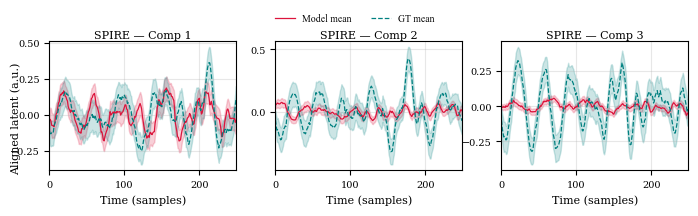

In [26]:
figure_save_dir = r"F:\comp_project\synthecticData\MMGPVAE"

fig, axes, sem_corrs = plot_shared1_mean_sem2(
    priv2, gt_private2_all,
    dims=(0,1,2),
    savepath=os.path.join(figure_save_dir, "D1_priv2MMGPVAE_private2_mean_sem.pdf"),
    width_in=6.9, base_fontsize=8,row_height_in=2,line_width=0.9, panel_labels=False, legend_headroom=0.001
)

In [27]:
for name, lat in [("shared", shared), ("priv1", priv1), ("priv2", priv2)]:
    for gt_name, gt in [
        ("gt_shared_base", gt_shared_base_all),
        ("gt_shared1",     gt_shared1_all),
        ("gt_shared2",     gt_shared2_all),
        ("gt_priv1",       gt_private1_all),
        ("gt_priv2",       gt_private2_all),
    ]:
        _, _, cca_corrs = _cca_align(lat, gt)
        print(name, "vs", gt_name, ":", cca_corrs)


shared vs gt_shared_base : [0.06369367 0.03801512 0.00712093]
shared vs gt_shared1 : [0.06463556 0.04034576 0.0056645 ]
shared vs gt_shared2 : [0.06340617 0.03684145 0.005978  ]
shared vs gt_priv1 : [0.04077741 0.02926364 0.00099489]
shared vs gt_priv2 : [0.08070018 0.02950629 0.0070708 ]
priv1 vs gt_shared_base : [0.06489852 0.01893446 0.00371599]
priv1 vs gt_shared1 : [0.06664163 0.02270245 0.00547601]
priv1 vs gt_shared2 : [0.06637649 0.0194926  0.00297053]
priv1 vs gt_priv1 : [0.04915145 0.03153352 0.01443647]
priv1 vs gt_priv2 : [0.0659737  0.0476853  0.01138559]
priv2 vs gt_shared_base : [0.05369734 0.01992778 0.0053321 ]
priv2 vs gt_shared1 : [0.05726546 0.02296172 0.00270599]
priv2 vs gt_shared2 : [0.05414735 0.02235699 0.00149339]
priv2 vs gt_priv1 : [0.04835764 0.02250993 0.01263023]
priv2 vs gt_priv2 : [0.06411274 0.02612918 0.00774267]


# Saving the MMGPVAE model

In [12]:
save_multimodal(net, n_encode, n_decode, test_data_unbatched, FOURIER = True,
                    name = MMGPVAE, zero_image = 1,
                    zero_neuron = 1, mmgpvae= True, gpfa= False, gpvae=False)

torch.Size([60, 60])
torch.Size([60, 60])
